In [4]:
!pip install pmdarima

In [5]:
#Basic Libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from pandas import Series
import statsmodels.api as sm

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
sns.set_style("whitegrid")
%matplotlib inline
import altair as alt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Timeseries model libraries
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

#Performance metric libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import cufflinks
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

## Import dataset
First let's welcome our dataset

In [6]:
reliance_raw=pd.read_csv("/content/RELIANCE.csv")

## print shape of dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(reliance_raw.shape))
print (reliance_raw.info())

The shape of the  data is (row, column):(5306, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4792 non-null   float64
 14  %Deliverble         4792 non-null   float64
dtypes: f

In [7]:
reliance_raw.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


## Dataset Details


Description of columns in the file:

* Date - Date of trade
* symbol - Name of the company (Reliance)
* Series - We have only one series(EQ): It stands for Equity. In this series intraday trading is possible in addition to delivery
* Prev Close - Refers to the prior day's final price of a security when the market officially closes for the day.
* Open - The open is the starting period of trading on a securities exchange or organized over-the-counter market.
* High -  Highest price at which a stock traded during the course of the trading day.
* Low - Lowest price at which a stock traded during the course of the trading day.
* Last - The last price of a stock is just one price to consider when buying or selling shares. The last price is simply the most recent one
* Close - The close is a reference to the end of a trading session in the financial markets when the markets close for the day.
* VWAP(Volume-weighted average price)- It is the ratio of the value traded to total volume traded over a particular time horizon. It is a measure of the average price at which a stock is traded over the trading horizon
* Volume - It is the amount of a security that was traded during a given period of time
* Turnover -It is a measure of sellers versus buyers of a particular stock. It is calculated by dividing the daily volume of a stock by the "float" of a stock, which is the number of shares available for sale by the general trading public.
* Trades- The number of shares being traded on a given day is called trading volumes
* Deliverabe Volume -  quantity of shares which actually move from one set of people (who had those shares in their demat account before today and are selling today) to another set of people (who have purchased those shares
* %Deliverable - shares which are actually transferred from one person's to another's demat account.

In [8]:
reliance_raw.dtypes

Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object

In [9]:
#Checking out the statistical measures
reliance_raw.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2.456000e+03,4.792000e+03,4792.000000
mean,1010.984866,1012.602375,1026.823803,996.886977,1011.157143,1011.316839,1011.937409,5.583028e+06,6.076715e+14,1.452306e+05,2.280885e+06,0.435039
std,570.987079,572.575893,581.986757,560.703328,570.938608,571.046753,571.222520,4.983793e+06,8.369739e+14,1.297557e+05,1.882665e+06,0.144722
min,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,572.137500,572.925000,582.950000,564.237500,572.062500,572.512500,573.190000,2.836454e+06,2.203354e+14,7.215900e+04,1.194524e+06,0.323325
50%,937.950000,939.000000,950.075000,927.550000,939.025000,938.275000,939.785000,4.213432e+06,3.662999e+14,1.021435e+05,1.810434e+06,0.449450
75%,1247.387500,1247.675000,1267.350000,1227.450000,1248.287500,1248.275000,1247.375000,6.602604e+06,6.656490e+14,1.686702e+05,2.752935e+06,0.544300
max,3220.850000,3298.000000,3298.000000,3141.300000,3223.000000,3220.850000,3197.750000,6.523089e+07,1.473434e+16,1.428490e+06,3.495888e+07,0.978300


**Insights:**
* There are many outliers in our dataset as we can see the max is 3 times the 75th percentile
* The standard deviation and other statistical measurements is more or less equal among all the features


<a id="section-two"></a>
# Data preparation
Inorder for our machine learning algorithm to perform well, we need to cleanse our data. In our case, we don't have much garbage to clean except few null values. Also let's also extract few more features from the time to perform indepth EDA

In [10]:
#Creating a copy
reliance_analysis=reliance_raw.copy()

#Coverting date column to datetime data type
reliance_analysis['Date'] = reliance_analysis['Date'].apply(pd.to_datetime)

#Extracting Month, Week, Day,Day of week
reliance_analysis["Month"] = reliance_analysis.Date.dt.month
reliance_analysis["Week"] = reliance_analysis.Date.dt.week
reliance_analysis["Day"] = reliance_analysis.Date.dt.day
reliance_analysis["Day of week"] = reliance_analysis.Date.dt.dayofweek


#Setting date column as index
reliance_analysis.set_index("Date", drop=False, inplace=True)
reliance_analysis.iloc[:,15:19].head()

,Month,Week,Day,Day of week
Date,,,,
2000-01-03,1,1,3,0
2000-01-04,1,1,4,1
2000-01-05,1,1,5,2
2000-01-06,1,1,6,3
2000-01-07,1,1,7,4


As you notice we have few new features assembled due to extraction. Let's gid rid of the null values by imputing it with mean value.

In [11]:
#Imputing null values with mean
reliance_analysis.fillna(reliance_analysis.mean(),inplace=True)

#Checking for null values
reliance_analysis.isnull().sum()

Date                  0
Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
Month                 0
Week                  0
Day                   0
Day of week           0
dtype: int64

<a id="section-three"></a>
# Data Visualization
Exploratory data analysis is a core part of time series analysis. In this phase, we will witness a lot of line graphs which can help us understand the trend, seasonality and many other concepts from time series analysis

## Distribution of stock measures
Let's witness the histogram distribution of the stock measures such as open,close,high,low and as well as VWAP

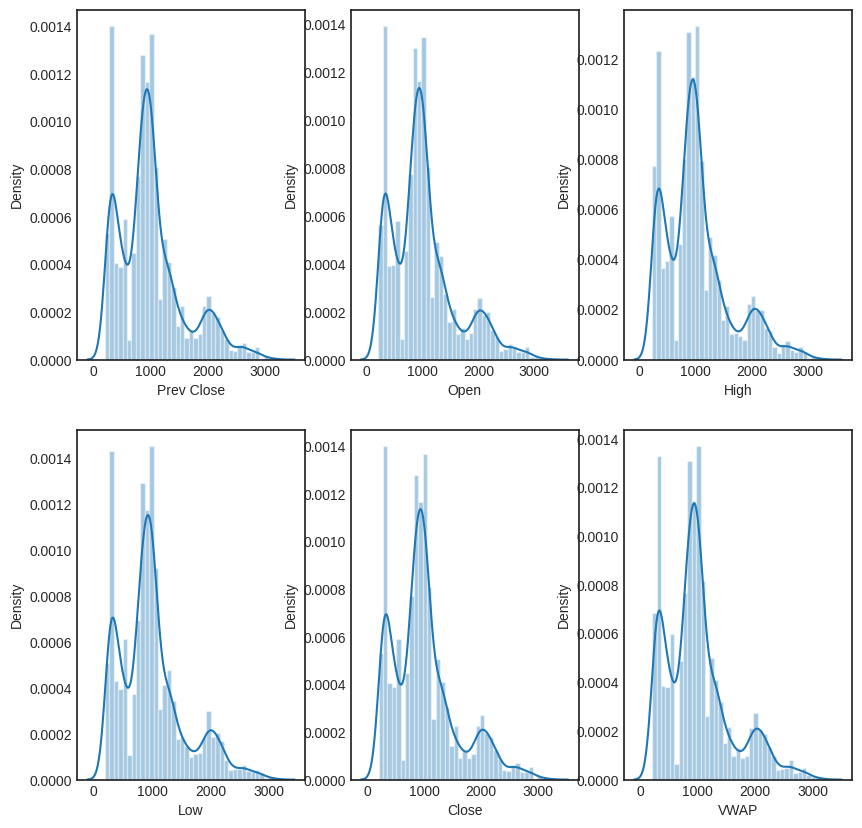

In [12]:
#Size and style of the plot
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')

#Subplots of distplot
plt.subplot(231)
sns.distplot(reliance_analysis['Prev Close'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(232)
sns.distplot(reliance_analysis['Open'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(233)
sns.distplot(reliance_analysis['High'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(234)
sns.distplot(reliance_analysis['Low'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(235)
sns.distplot(reliance_analysis['Close'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(236)
sns.distplot(reliance_analysis['VWAP'])
fig = plt.gcf()
fig.set_size_inches(10,10)

**Insights:**
* All the meaures exhibit equal distribution property
* All the distributions are right skewed

## Univariate Analysis
Let's see the trend of single factor over time

## VWAP over time
Now let's see the Volume-weighted average price over the time. Please feel free to use the range slider to analyzeover time

In [13]:
fig = px.line(reliance_analysis, x='Date', y='VWAP',title='VWAP over Years(Use Rangeslider to slide over time)')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

**Insights:**
* There has been a gradual increase in the trend of VWAP over years
* There were two spikes in Jan 2008 and May-Oct 2009

 Mukesh Ambani-controlled company are trading at near their all-time high levels of about Rs 1,625, a price that was last seen over nine-and-a-half years ago in January 2008. Reliance Industries shares ended at Rs 1,621.15 on Wednesday. By contrast, it saw an intra-day high of Rs 1,649 and previous closing high of Rs 1,610 in January 2008. [News here](https://www.financialexpress.com/market/reliance-industries-ril-share-price-all-time-high-10-year-return-zero-jul-2017/780392/)

## Univariate analysis of Open,Close,High and Low
Let's see open,close, high and low measures over years

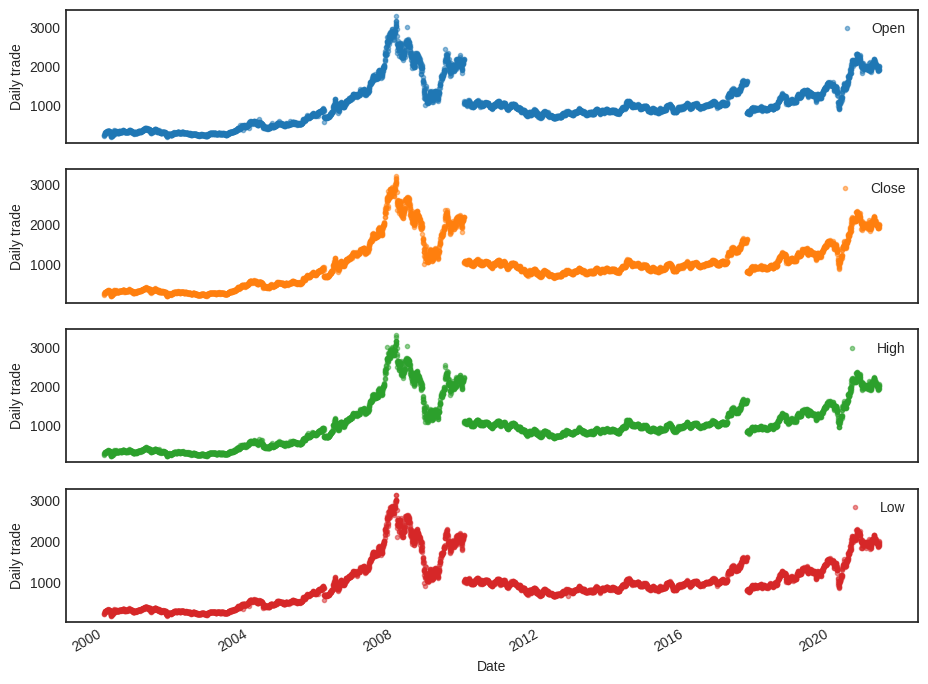

In [14]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = reliance_analysis[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

**Insights:**
* As we know, all these parameters follow the same pattern without much deviation
* Theres a break between 2008-2012 and 2016-2020. It signifies a sudden dip in the market for Reliance.

## Univariate analysis of Volume of share over the years
Let's see the volume of shares that have been traded over NIFTY 50.

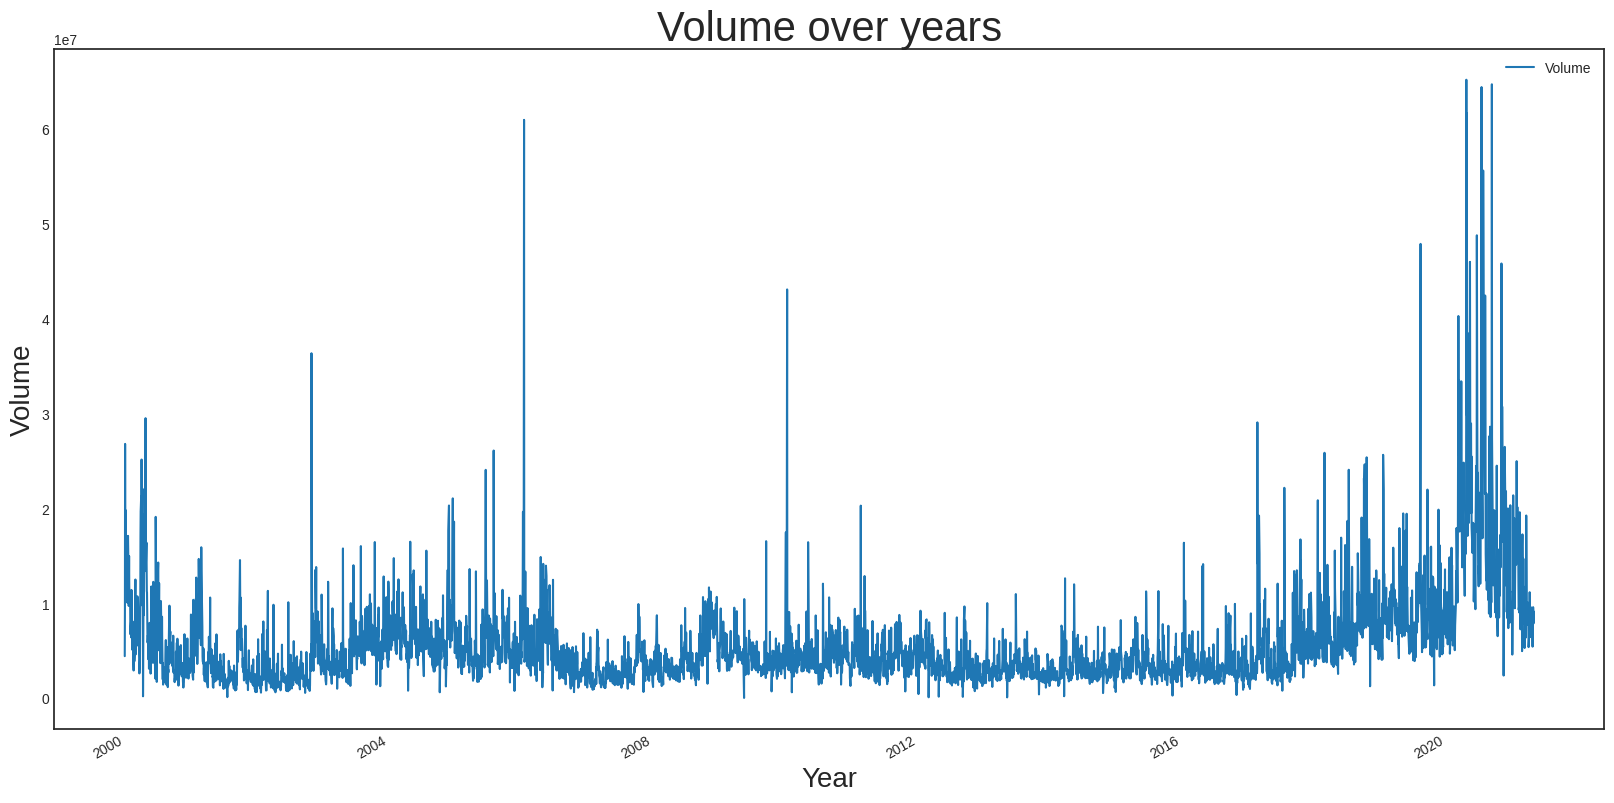

In [15]:
ax=reliance_analysis[['Volume']].plot(stacked=True)
ax.set_title('Volume over years',fontsize= 30)
ax.set_xlabel('Year',fontsize = 20)
ax.set_ylabel('Volume',fontsize = 20)
plt.show()

**Insights:**
* There have been huge number of shared in 2020. This could be due to the reign of Jio and Investment by top tech gaints like Facebook and Google.
* The thin phase lie between 2008-2016, in this phase there hasn't been  big volumes traded during these years.
* Reliance have a strong foot in India and has got the trust of the citizens of India that is a valuable company.

## Moving average analysis
Moving average is a smoothing technique applied to time series to remove the fine-grained variation between time steps.The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. Moving averages are a simple and common type of smoothing used in time series analysis and time series forecasting.Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.The “moving” part in the moving average refers to the fact that the window defined by the window width is slid along the time series to calculate the average values in the new series.

In our project we consider the moving mean and standard deviation for 3,7 and 30 days. Thanks to Vopani for this wonderful piece of code.

In [18]:
#Making a copy
reliance_lag=reliance_analysis.copy()
#Reset index
reliance_lag.reset_index(drop=True, inplace=True)
#Creating lag features
lag_features = ["High", "Low", "Volume", "VWAP"]

# Taking the number of days in window
window1 = 3
window2 = 7
window3 = 30

#Rolling mean
df_rolled_3d = reliance_lag[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = reliance_lag[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = reliance_lag[lag_features].rolling(window=window3, min_periods=0)

#Moving average
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

#Standard deviation
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

# Adding the features to the dataframe
for feature in lag_features:
    reliance_lag[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    reliance_lag[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    reliance_lag[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    reliance_lag[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    reliance_lag[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    reliance_lag[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

reliance_lag.fillna(reliance_lag.mean(), inplace=True)

#Setting Date as index
reliance_lag.set_index("Date", drop=False, inplace=True)
reliance_lag.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,VWAP_mean_lag3,VWAP_mean_lag7,VWAP_mean_lag30,VWAP_std_lag3,VWAP_std_lag7,VWAP_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,...,5595386.0,1671437.75,2045707.25,2583829.50,1011.416748,1010.776978,1007.152771,13.108312,21.450975,47.009243
2000-01-04,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,...,4456424.0,1671437.75,2045707.25,2583829.50,249.369995,249.369995,249.369995,13.108312,21.450975,47.009243
2000-01-05,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,...,6972151.0,3557775.25,3557775.25,3557775.25,256.445007,256.445007,256.445007,10.005561,10.005561,10.005561
2000-01-06,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,...,13592662.0,11739778.00,11739778.00,11739778.00,262.559998,262.559998,262.559998,12.737163,12.737163,12.737163
2000-01-07,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,...,14115068.0,8790159.00,9642262.00,9642262.00,277.920013,270.782501,270.782501,16.193483,19.457516,19.457516


We have created the moving average and standard deviation for the respective days across High, Low, Volume, VWAP

## High vs Low with mean and standard deviation lag - 30 days

In this notebook, I'm considering only 30 days for comparison to get a lower noise. You can copy and edit this code to change the window according to your wish. Here we compare the High vs Low with mean and standard deviation.

In [19]:
#Printing the high curve
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High'],
         name='High',
    line=dict(color='green'),
    opacity=0.8))

#Printing the low curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low'],
         name='Low',
    line=dict(color='orange'),
    opacity=0.8))

#Printing the high lag mean-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High_mean_lag30'],
         name='High_mean_lag30',
    line=dict(color='red'),
    opacity=0.8))

#Printing the high lag standard deviation-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High_std_lag30'],
         name='High_std_lag30',
    line=dict(color='royalblue'),
    opacity=0.8))

#Printing the low lag mean-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low_mean_lag30'],
         name='Low_mean_lag30',
    line=dict(color='yellow'),
    opacity=0.8))

#Printing the low lag standard deviation-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low_std_lag30'],
         name='Low_std_lag30',
    line=dict(color='pink'),
    opacity=0.8))

#Updating the time axis
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Update the title
fig.update_layout(title_text='High Vs Low with mean lag and standard deviation lag',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

You can click on the legends in the plotly graph to see individual curves
**Insights:**
* Considering the standard deviation,there's a high deviation whenever there is a drop in the price of stock.
* With the help of standard deviation we can understand where the company faced loss.
* Even though the lag curve isn't much less with noise, we have a clear idea on how the high and low price move over time

## Building AUTO ARIMA model

For building the auto arima model,first let's split our training and testing data. For time series analysis we step back from using train test split as our data involves time and splitting can cause the mix of date across both train and test dataset which is vulnerable for a data leakage. So we split based on the dates. Here we split the training and validation data based on the year 2019 where the data before 2019 is training data and data after 2019 is validation data

In [29]:
train = reliance_lag[reliance_lag.Date <= "2019"]
valid = reliance_lag[reliance_lag.Date > "2019"]

In [30]:
exogenous_features = ['High_mean_lag3','High_mean_lag7', 'High_mean_lag30', 'High_std_lag3', 'High_std_lag7',
       'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7', 'Low_mean_lag30',
       'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30', 'Volume_mean_lag3',
       'Volume_mean_lag7', 'Volume_mean_lag30', 'Volume_std_lag3',
       'Volume_std_lag7', 'Volume_std_lag30', 'VWAP_mean_lag3',
       'VWAP_mean_lag7', 'VWAP_mean_lag30', 'VWAP_std_lag3', 'VWAP_std_lag7',
       'VWAP_std_lag30','Month', 'Week', 'Day', 'Day of week']

### Training and prediction
Let's train our model with auto arima. Here the model selects the parameter p,q,d value in a normal arima model by itself by determining AIC value ( Akaike information criterion ) .AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. So AUTO ARIMA prefers the parameters which can reap less information loss

In [31]:
model = auto_arima(train.Close, exogenous=train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train.Close, exogenous=train[exogenous_features])

pred = model.predict(n_periods=len(valid), exogenous=valid[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=46543.176, Time=6.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46584.126, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46580.144, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46580.136, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46582.270, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46571.665, Time=2.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46569.192, Time=4.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=46543.901, Time=8.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=46543.887, Time=7.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46582.130, Time=2.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=46555.194, Time=2.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=46552.392, Time=3.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=46544.443, Time=9.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=46541.324, Time=2.04 sec
 ARIMA(1,1,2)(0,0,0

### Plotting the forecasted values with the actual data
Let's plot the results and compare them with actual values

In [32]:
pred = pd.Series(pred)

In [33]:
pred.index = valid.index[:len(pred)]

In [34]:
pred

Date
2019-01-02    1118.358388
2019-01-03    1116.672804
2019-01-04    1116.818687
2019-01-07    1118.408092
2019-01-08    1120.233096
                 ...     
2021-04-26    1119.216778
2021-04-27    1119.216778
2021-04-28    1119.216778
2021-04-29    1119.216778
2021-04-30    1119.216778
Length: 576, dtype: float64

In [35]:
valid['Forecast_ARIMAX'] = pred

<Axes: xlabel='Date'>

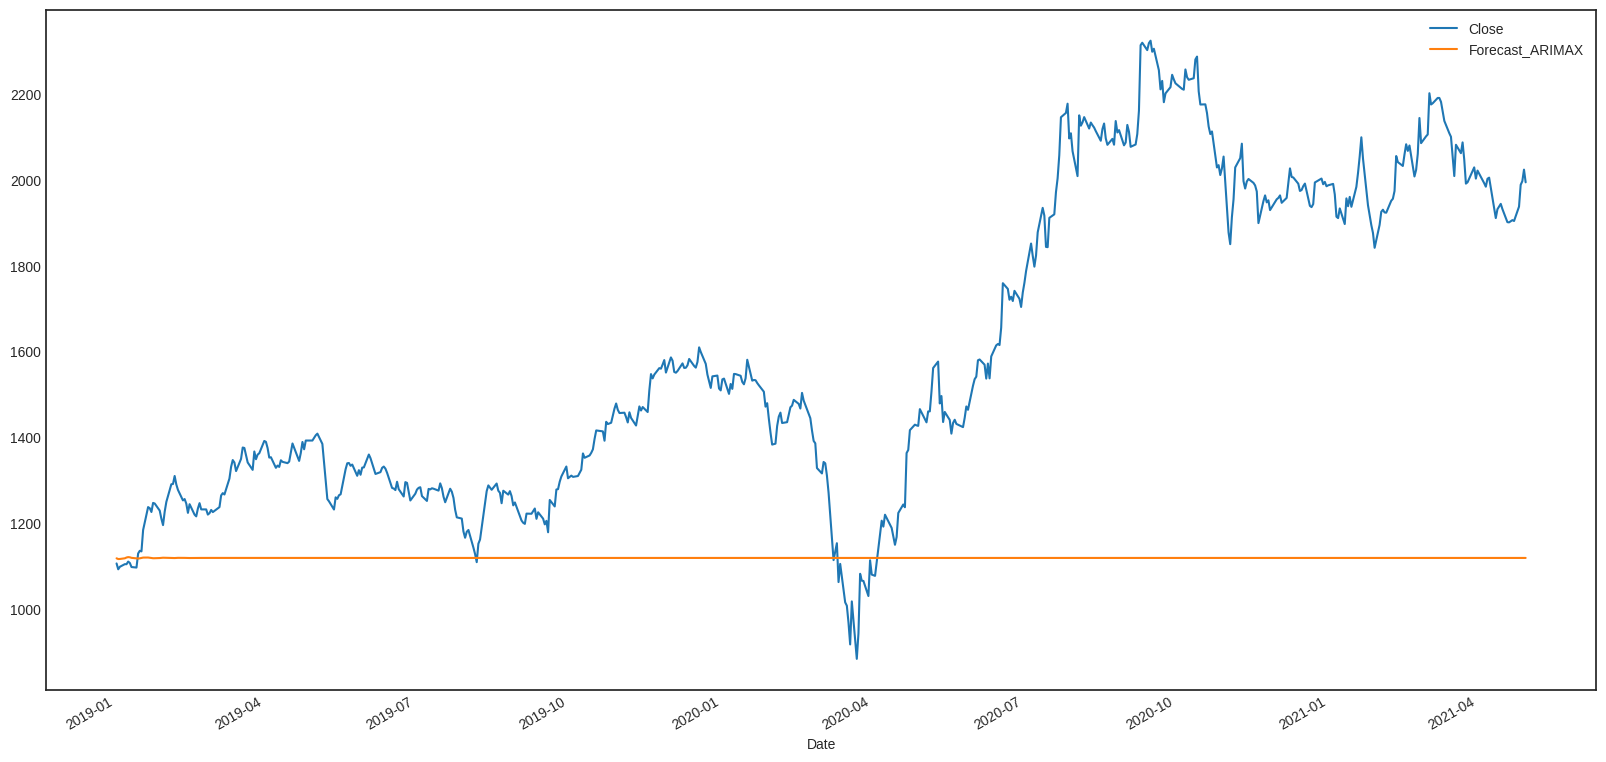

In [36]:
valid[["Close", "Forecast_ARIMAX"]].plot()

Fantastic we have got more or less a similar result. Our model has captured a good amount of information from training dataset. Let's look at the performance metrics

### Performance metrics-RMSE and MAE
Here we calculate how well our model performed with numbers with the help of RMSE and MAE. We hope that the erroe will be very low

In [37]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(valid.Close, valid.Forecast_ARIMAX))/10)
print("\nMAE of Auto ARIMAX:", mean_absolute_error(valid.Close, valid.Forecast_ARIMAX)/10)

RMSE of Auto ARIMAX: 60.27565833508098

MAE of Auto ARIMAX: 48.84134947328169
